In [6]:
# Bioinformatics
import pysam
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# General
import sys
import os
import re

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300

## General samples and cluster informations

In [7]:
conditions_colors = {
    "30H": (0.0,0.0,1.0,0.8), # blue
    "30H_del": (0.0,0.7,1.0,0.25), # turquoise
    "30D": (1.0,0.5,0.0,0.8), # orangered
    "30D_del": (1.0,0.75,0.0,0.25), # orange
    "0Gy": (0.5,0.5,0.5,0.8), # dark grey
    "0Gy_del": (0.7,0.7,0.7,0.25), # lighter grey
    "100Gy": (0.7,0.0,0.6,0.8), # purple
    "100Gy_del": (1.0,0.0,0.8,0.25), # pinkish
    "250Gy": (0.0,0.75,0.0,0.8), # darkgreen
    "250Gy_del": (0.0,1.0,0.0,0.25), # limegreen
    "500Gy": (1.0,0.0,0.0,0.8), # red
    "500Gy_del": (1.0,0.5,0.5,0.25), # pink
    "H": (0.0,0.0,1.0,0.8),
    "H_del": (0.0,0.7,1.0,0.25),
    "D": (1.0,0.25,0.0,0.8),
    "D_del": (1.0,0.75,0.0,0.25),
}

conditions_cmap = {
    "30H":plt.cm.Blues,
    "30D":plt.cm.Oranges,
    "0Gy":plt.cm.Greys,
    "100Gy":plt.cm.Purples,
    "250Gy":plt.cm.Greens,
    "500Gy":plt.cm.Reds,
    "H":plt.cm.Blues,
    "D":plt.cm.Oranges,
}

conditions_names = {
    "30H": "GR Hydrated",
    "30D": "GR Desiccated",
    "0Gy": "GR 0Gy IR",
    "100Gy": "GR 100Gy IR",
    "250Gy": "GR 250Gy IR",
    "500Gy": "GR 500Gy IR",
    "H": "ME Hydrated",
    "D": "ME Desiccated"
}

conditions_shape = {
    "30H": "o",
    "30D": "o",
    "0Gy": "o",
    "100Gy": "o",
    "250Gy": "o",
    "500Gy": "o",
    "H": "d",
    "D": "d"
}

# COVERAGE
average_coverage = {
    "ancestor":   291.1,
    "P500_C18_E3":250.6,
}

col_MA = (55/255, 126/255, 184/255)
col_ARC = (255/255, 127/255, 0/255)
col_TE = (152/255, 78/255, 163/255, 0.65)

# LENGTHS OF CHROMOSOMES
reference = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa"
fai = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

# TELOMERES
telomeres = {
    "Chrom_1":([0,1500000], [11000000, 18146847]),
    "Chrom_2":([0,2000000], [15000000, 16274841]),
    "Chrom_3":([0,4000000], [13500000, 20354777]),
    "Chrom_4":([0,1000000], [14000000, 15224634]),
    "Chrom_5":([0,5000000], [15500000, 16930519]),
    "Chrom_6":([0,2000000], [12000000, 13893210]),
}

# POSITIONS OF GENES, CDS AND REPEATS 
genes = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.genes.bed"
cds = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.CDS.bed"
repeats = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/avaga.TEannotation.26-02-20.defragmentedDraftAnnot.bed"

# REPEATS DATAFRAME
reps = {"CHR":[], "START":[], "END":[]}
for line in open(repeats, "r") :
    s = line.strip().split("\t")
    reps["CHR"].append(s[0])
    reps["START"].append(int(s[1]))
    reps["END"].append(int(s[2]))
    
repdf = pd.DataFrame().from_dict(reps)

In [8]:
clr = plt.rcParams['axes.prop_cycle'].by_key()['color']

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))

colors = [hex_to_rgb(c) for c in clr]
print(colors)

[[0.12156862745098039, 0.4666666666666667, 0.7058823529411765], [1.0, 0.4980392156862745, 0.054901960784313725], [0.17254901960784313, 0.6274509803921569, 0.17254901960784313], [0.8392156862745098, 0.15294117647058825, 0.1568627450980392], [0.5803921568627451, 0.403921568627451, 0.7411764705882353], [0.5490196078431373, 0.33725490196078434, 0.29411764705882354], [0.8901960784313725, 0.4666666666666667, 0.7607843137254902], [0.4980392156862745, 0.4980392156862745, 0.4980392156862745], [0.7372549019607844, 0.7411764705882353, 0.13333333333333333], [0.09019607843137255, 0.7450980392156863, 0.8117647058823529]]


In [9]:
cml = mpl.cm.tab20.colors
colors = [list(c) for c in cml]
#colors

# Deletions in ME H2C3 C6

### Read coverage once

In [10]:
cov_anc = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [12]:
cov_ilu = pd.read_csv(
    "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/coverage/H2C3.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ilu = cov_ilu.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [13]:
def parse_region_illu_only(input_illumina, ancestor, sample, chrom, start, end) :
    
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(input_illumina)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for rec in vcf_in.fetch(chrom, start, end) :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    return df_illu

In [15]:
vcf_ME = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"
df_illu = parse_region_illu_only(vcf_ME, "ancestor", "H2C3", "Chrom_6", start=2000000, end=5000000)
total_df = pd.merge(df_illu, cov_anc, on=["CHROM", "POS"], how="inner")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")

In [16]:
total_df

,CHROM,POS,QUAL,ALS,AAL,ADP,AAD,AAF,IAL,IDP,IAD,IAF,IGT,COV_ANC,COV_ILU
0,Chrom_6,2000266,90999.000000,"(C, T)","[C, T]",300,"(154, 146)",0.513333,"[C, T]",136.0,"(60, 76)",0.558824,"(0, 1)",333,141
1,Chrom_6,2000469,95826.203125,"(T, A)","[T, A]",248,"(134, 114)",0.540323,"[T, A]",126.0,"(67, 59)",0.531746,"(0, 1)",297,125
2,Chrom_6,2000470,96294.203125,"(A, G)","[A, G]",248,"(134, 114)",0.540323,"[A, G]",128.0,"(68, 60)",0.531250,"(0, 1)",294,125
3,Chrom_6,2000475,94297.000000,"(T, G)","[T, G]",247,"(134, 113)",0.542510,"[T, G]",129.0,"(69, 60)",0.534884,"(0, 1)",291,123
4,Chrom_6,2000478,92552.203125,"(T, C)","[T, C]",242,"(132, 110)",0.545455,"[T, C]",126.0,"(66, 60)",0.523810,"(0, 1)",294,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60266,Chrom_6,4999880,101949.000000,"(A, G)","[A, G]",207,"(118, 89)",0.570048,"[A, G]",125.0,"(65, 60)",0.520000,"(0, 1)",288,136
60267,Chrom_6,4999888,101606.000000,"(T, C)","[T, C]",205,"(117, 88)",0.570732,"[T, C]",126.0,"(67, 59)",0.531746,"(0, 1)",285,139
60268,Chrom_6,4999912,79468.500000,"(T, G)","[T, G]",198,"(86, 112)",0.565657,"[T, G]",119.0,"(58, 61)",0.512605,"(0, 1)",269,134
60269,Chrom_6,4999950,75651.500000,"(A, C)","[A, C]",210,"(114, 96)",0.542857,"[A, C]",126.0,"(71, 55)",0.563492,"(0, 1)",282,137


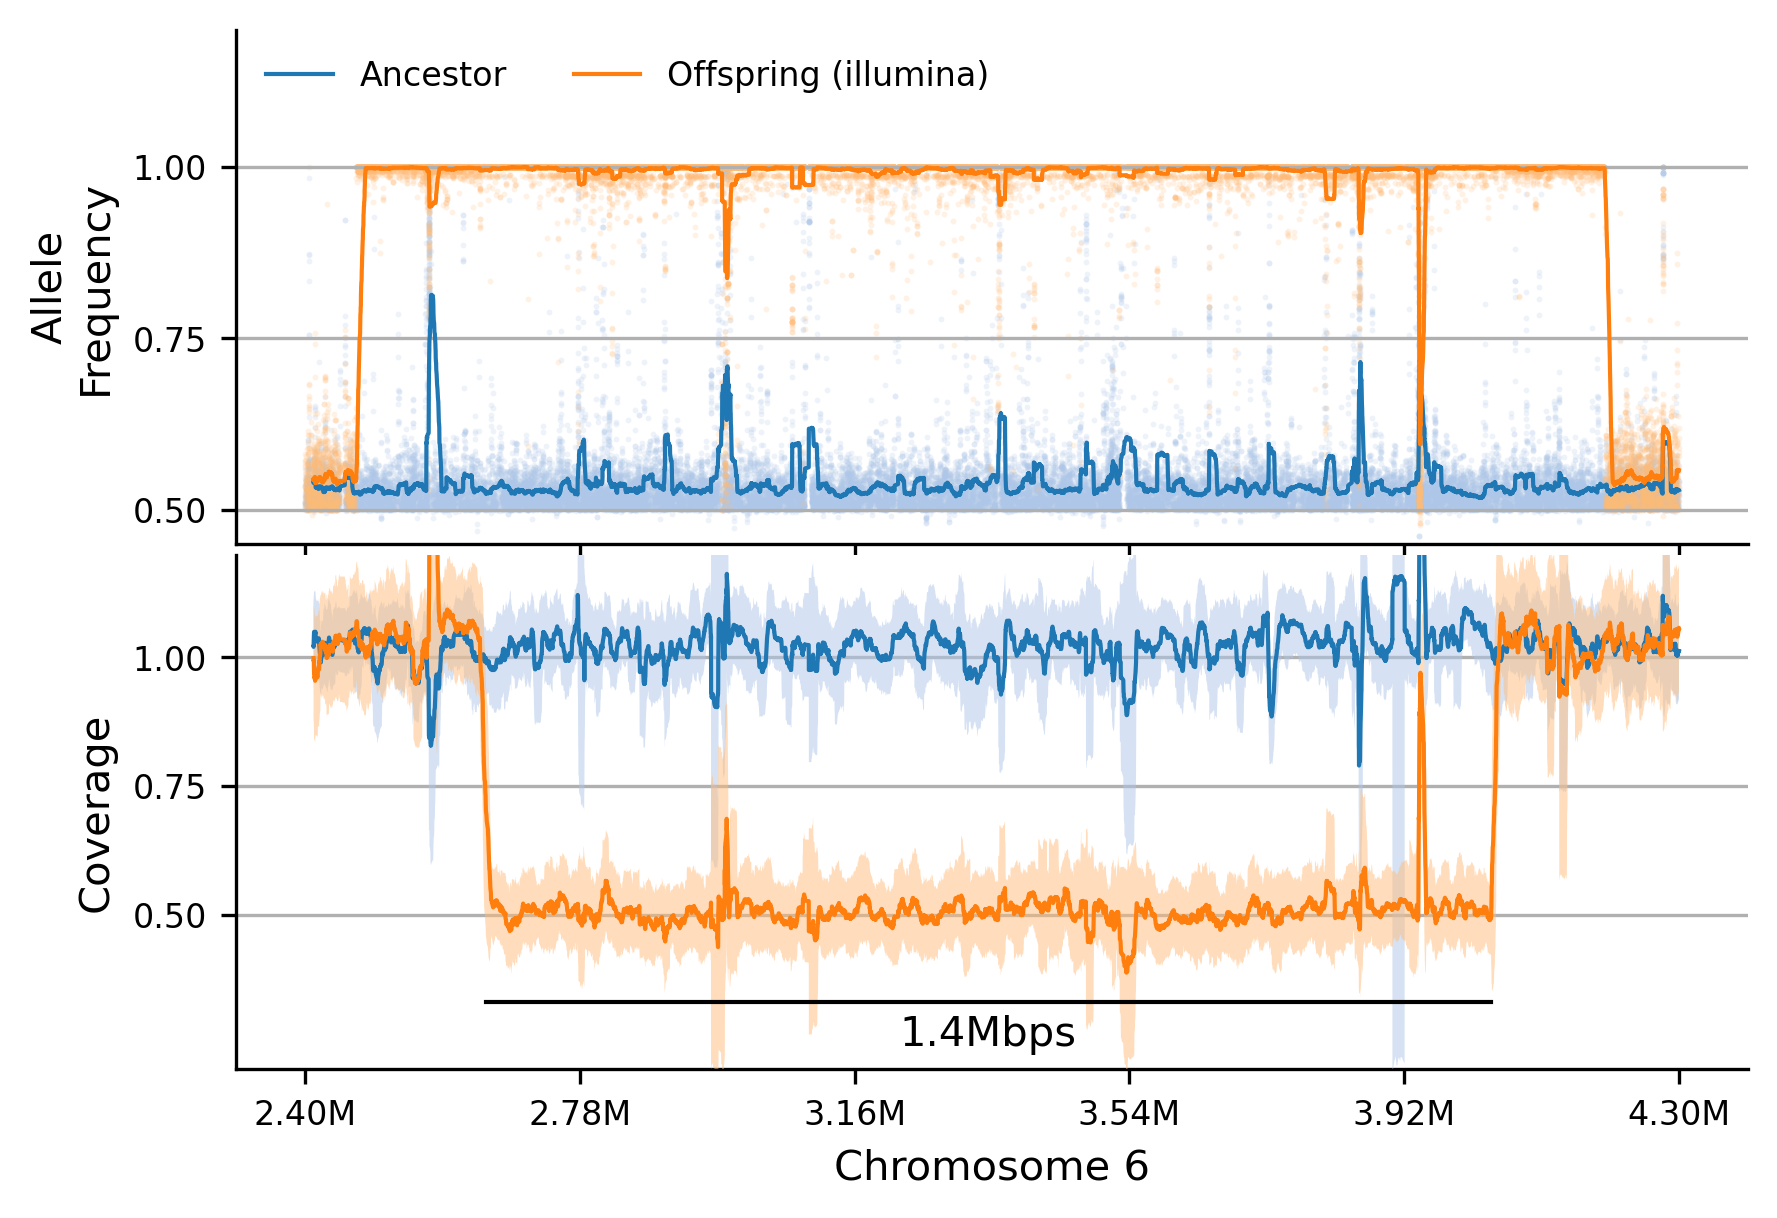

In [19]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

# 2400000 - 4300000
flt = total_df.query("POS > 2400000 & POS < 4300000 & QUAL >= 1000")
flt = flt.dropna()

ax = axs[0]

AAF = flt["AAF"].rolling(window=200).mean()
AAF_std = flt["AAF"].rolling(window=200).std()
IAF = flt["IAF"].rolling(window=200).mean()
IAF_std = flt["IAF"].rolling(window=200).std()

ax.scatter(flt["POS"], flt["AAF"], s=2, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], AAF, color=colors[0], lw=1.0, zorder=15, label="Ancestor")

ax.scatter(flt["POS"], flt["IAF"], s=2, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], IAF, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.45, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Allele\nFrequency", fontsize=10)
ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper left")

# Coverage
ax = axs[1]

ADP_scaled = flt["COV_ANC"]/341 # use median value from notebook 05
Arol = ADP_scaled.rolling(window=200).mean()
Arol_std = ADP_scaled.rolling(window=200).std()

IDP_scaled = flt["COV_ILU"]/152 # use median value from notebook 05
Irol = IDP_scaled.rolling(window=200).mean()
Irol_std = IDP_scaled.rolling(window=200).std()

ax.plot(flt["POS"], Arol, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

ax.plot(flt["POS"], Irol, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.2, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Coverage", fontsize=10)

start = min(flt["POS"])
end = max(flt["POS"])
ticks = np.linspace(start, end, 6)
ticklabels = []
for t in ticks :
    ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=8) #, fontsize=12)
ax.set_xlabel("Chromosome 6", fontsize=10)

bs, be = 2650000, 4040000
byt = 0.33
ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.1f}Mbps".format((be-bs)/1e6), ha="center", va="top")

for ax in axs :
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.subplots_adjust(hspace=0.02)
plt.show()

# Deletion MA H2B4 C1

### Read coverage once

In [20]:
cov_anc = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [21]:
cov_ilu = pd.read_csv(
    "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/coverage/H2B4.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ilu = cov_ilu.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [22]:
def parse_region_illu_only(input_illumina, ancestor, sample, chrom, start, end) :
    
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(input_illumina)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for rec in vcf_in.fetch(chrom, start, end) :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    return df_illu

In [23]:
vcf_ME = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"
df_illu = parse_region_illu_only(vcf_ME, "ancestor", "H2B4", "Chrom_1", start=14000000, end=17000000)
total_df = pd.merge(df_illu, cov_anc, on=["CHROM", "POS"], how="inner")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")

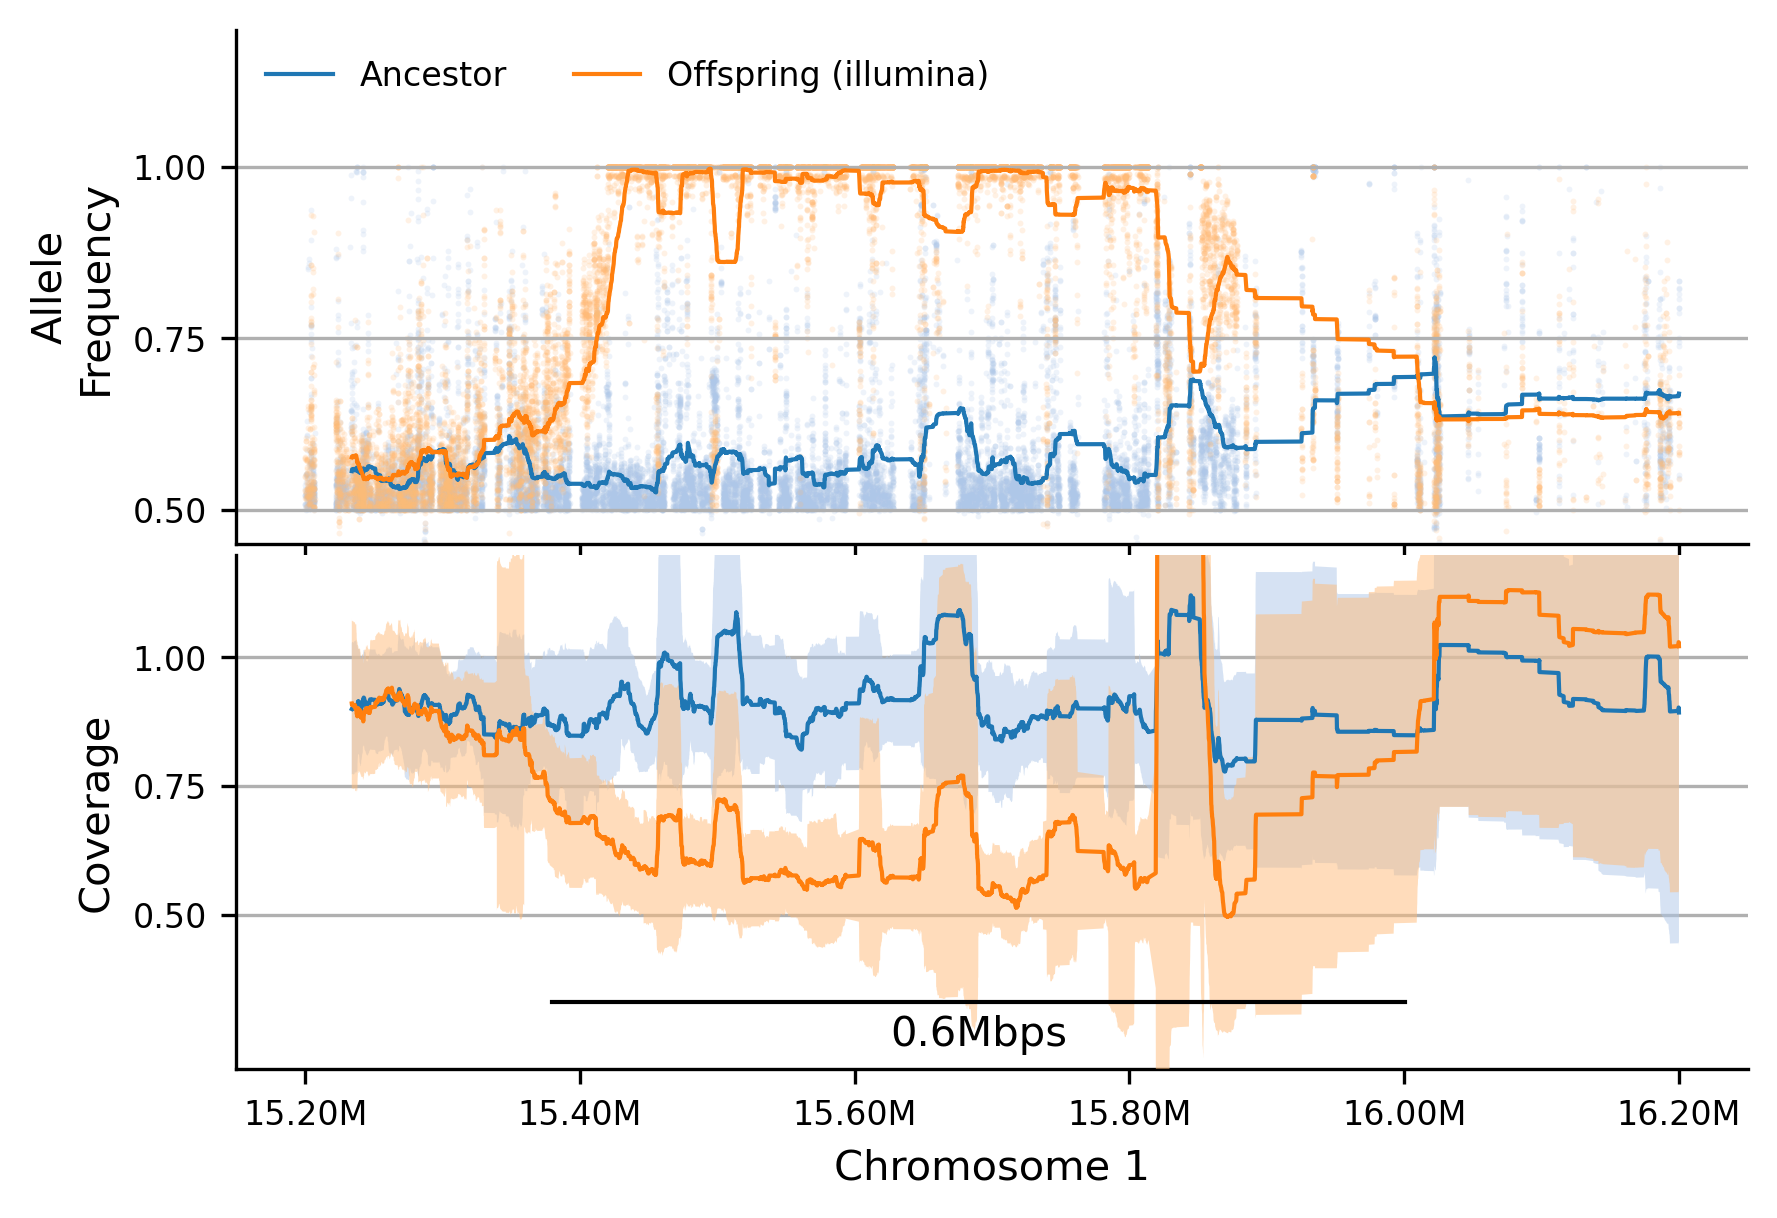

In [24]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

# 2400000 - 4300000
flt = total_df.query("POS > 15200000 & POS < 16200000 & QUAL >= 25000")
flt = flt.dropna()

ax = axs[0]

AAF = flt["AAF"].rolling(window=500).mean()
AAF_std = flt["AAF"].rolling(window=500).std()
IAF = flt["IAF"].rolling(window=500).mean()
IAF_std = flt["IAF"].rolling(window=500).std()

ax.scatter(flt["POS"], flt["AAF"], s=2, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], AAF, color=colors[0], lw=1.0, zorder=15, label="Ancestor")

ax.scatter(flt["POS"], flt["IAF"], s=2, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], IAF, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.45, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Allele\nFrequency", fontsize=10)
ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper left")

# Coverage
ax = axs[1]

ADP_scaled = flt["COV_ANC"]/341 #flt["COV_ANC"].mean()
Arol = ADP_scaled.rolling(window=500).mean()
Arol_std = ADP_scaled.rolling(window=500).std()

IDP_scaled = flt["COV_ILU"]/122 #flt["COV_ILU"].mean()
Irol = IDP_scaled.rolling(window=500).mean()
Irol_std = IDP_scaled.rolling(window=500).std()

ax.plot(flt["POS"], Arol, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

ax.plot(flt["POS"], Irol, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.2, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Coverage", fontsize=10)

start = min(flt["POS"])
end = max(flt["POS"])
ticks = np.linspace(start, end, 6)
ticklabels = []
for t in ticks :
    ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=8) #, fontsize=12)
ax.set_xlabel("Chromosome 1", fontsize=10)

bs, be = 15380000, 16000000
byt = 0.33
ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.1f}Mbps".format((be-bs)/1e6), ha="center", va="top")

for ax in axs :
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.subplots_adjust(hspace=0.02)
plt.show()

# Deletion MA H4A4 C6

### Read coverage once

In [25]:
cov_anc = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [26]:
cov_ilu = pd.read_csv(
    "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/coverage/H4A4.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ilu = cov_ilu.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [27]:
def parse_region_illu_only(input_illumina, ancestor, sample, chrom, start, end) :
    
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(input_illumina)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for rec in vcf_in.fetch(chrom, start, end) :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    return df_illu

In [28]:
vcf_ME = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"
df_illu = parse_region_illu_only(vcf_ME, "ancestor", "H4A4", "Chrom_6", start=6000000, end=10000000)

In [29]:
total_df = pd.merge(df_illu, cov_anc, on=["CHROM", "POS"], how="inner")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")

In [30]:
total_df

,CHROM,POS,QUAL,ALS,AAL,ADP,AAD,AAF,IAL,IDP,IAD,IAF,IGT,COV_ANC,COV_ILU
0,Chrom_6,6000015,83012.5,"(G, T)","[G, T]",256,"(123, 133)",0.519531,"[G, T]",368,"(181, 187)",0.508152,"(0, 1)",319,377
1,Chrom_6,6000098,73081.5,"(A, G)","[A, G]",271,"(132, 139)",0.512915,"[A, G]",327,"(153, 174)",0.532110,"(0, 1)",337,356
2,Chrom_6,6000164,74584.5,"(C, T)","[C, T]",282,"(137, 145)",0.514184,"[C, T]",336,"(152, 184)",0.547619,"(0, 1)",344,365
3,Chrom_6,6000233,104412.0,"(T, A)","[T, A]",273,"(138, 135)",0.505495,"[T, A]",348,"(189, 159)",0.543103,"(0, 1)",356,368
4,Chrom_6,6000242,105990.0,"(G, T)","[G, T]",278,"(139, 139)",0.500000,"[G, T]",357,"(189, 168)",0.529412,"(0, 1)",363,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81830,Chrom_6,9999573,110485.0,"(ATT, A)","[ATT, A]",348,"(195, 153)",0.560345,"[ATT, A]",380,"(201, 179)",0.528947,"(0, 1)",390,412
81831,Chrom_6,9999575,5.9,"(T, *)",[T],356,"(203, 153)",0.570225,[T],390,"(211, 179)",0.541026,"(0, 0)",390,414
81832,Chrom_6,9999756,115864.0,"(G, A)","[G, A]",331,"(162, 169)",0.510574,"[G, A]",392,"(175, 217)",0.553571,"(0, 1)",372,408
81833,Chrom_6,9999763,115896.0,"(T, C)","[T, C]",335,"(162, 173)",0.516418,"[T, C]",393,"(177, 216)",0.549618,"(0, 1)",372,414


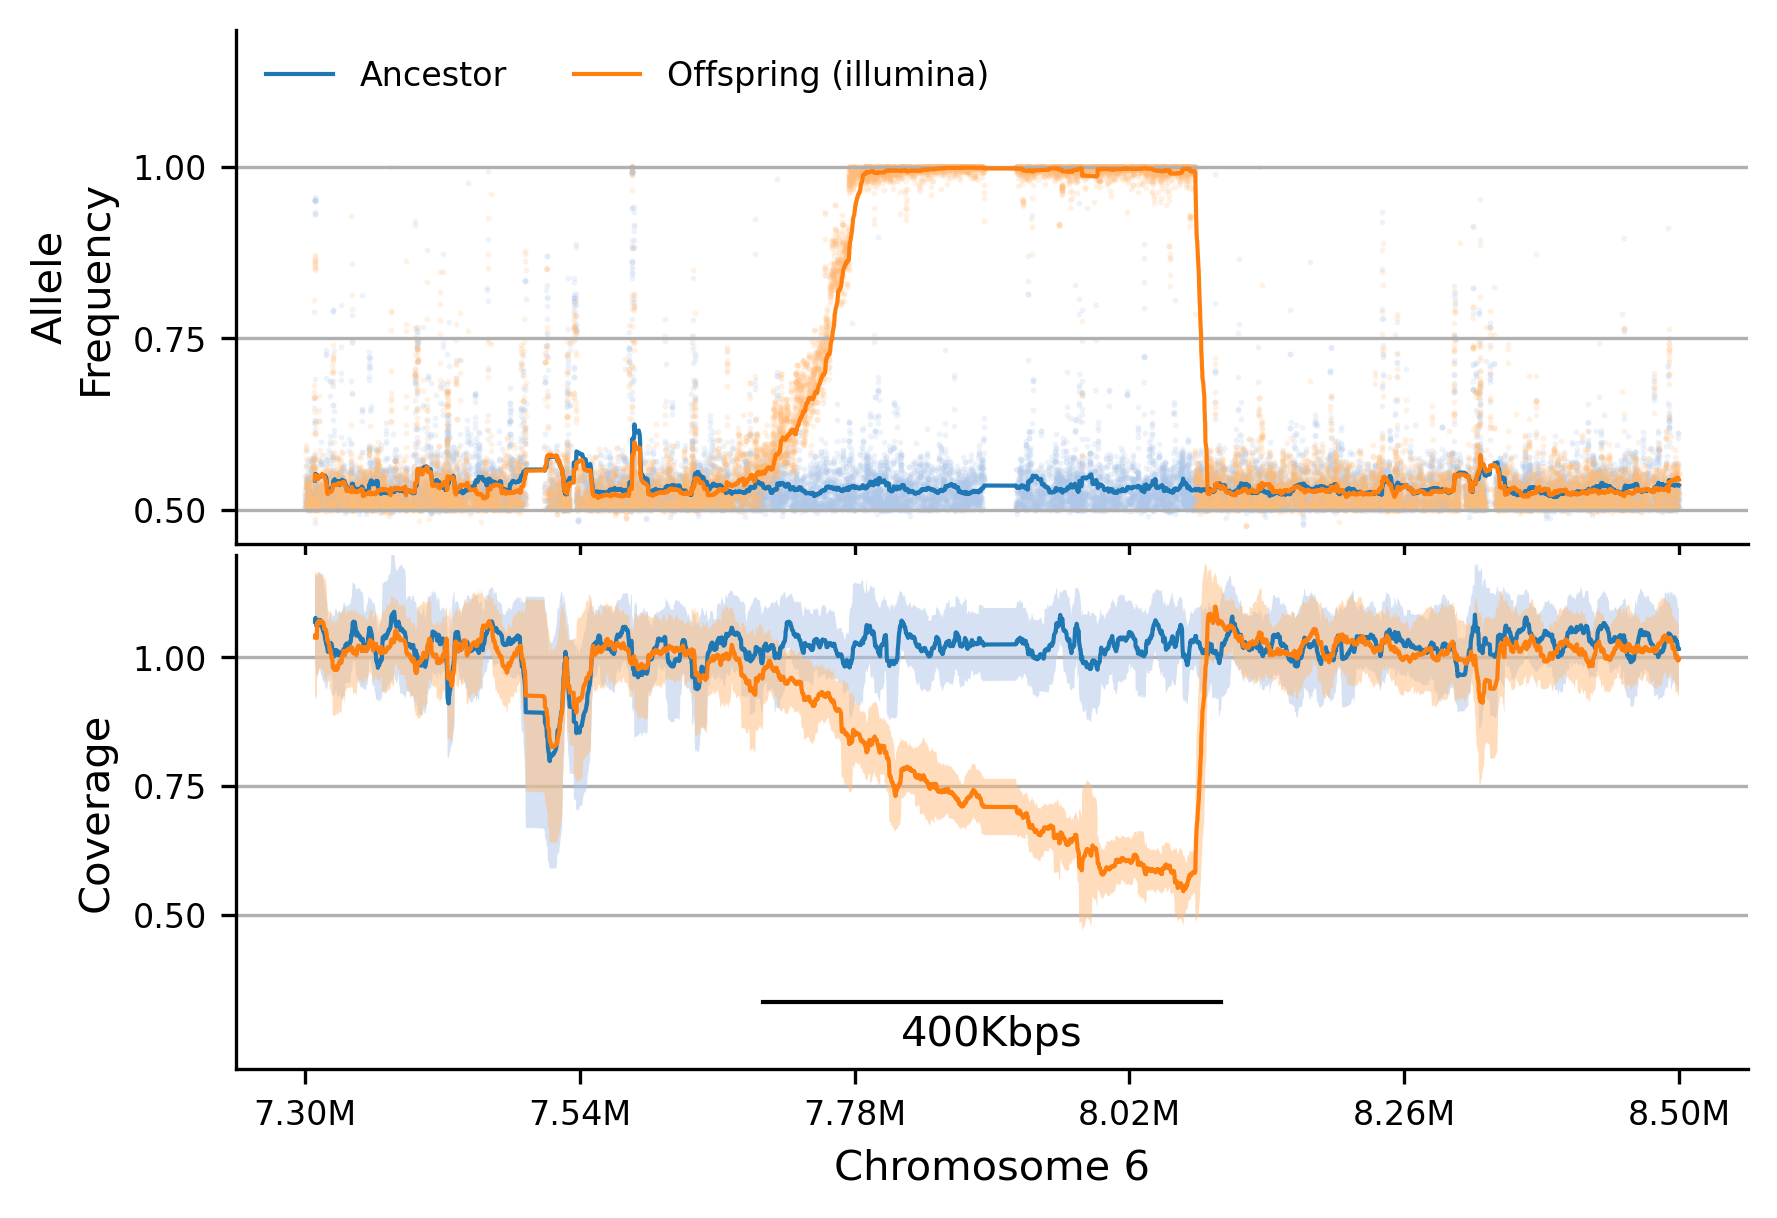

In [31]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

# 2400000 - 4300000
flt = total_df.query("POS > 7300000 & POS < 8500000 & QUAL >= 25000")
flt = flt.dropna()

ax = axs[0]

AAF = flt["AAF"].rolling(window=200).mean()
AAF_std = flt["AAF"].rolling(window=200).std()
IAF = flt["IAF"].rolling(window=200).mean()
IAF_std = flt["IAF"].rolling(window=200).std()

ax.scatter(flt["POS"], flt["AAF"], s=2, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], AAF, color=colors[0], lw=1.0, zorder=15, label="Ancestor")

ax.scatter(flt["POS"], flt["IAF"], s=2, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], IAF, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.45, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Allele\nFrequency", fontsize=10)
ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper left")

# Coverage
ax = axs[1]

ADP_scaled = flt["COV_ANC"]/341 #flt["COV_ANC"].mean()
Arol = ADP_scaled.rolling(window=200).mean()
Arol_std = ADP_scaled.rolling(window=200).std()

IDP_scaled = flt["COV_ILU"]/409 #flt["COV_ILU"].mean()
Irol = IDP_scaled.rolling(window=200).mean()
Irol_std = IDP_scaled.rolling(window=200).std()

ax.plot(flt["POS"], Arol, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

ax.plot(flt["POS"], Irol, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.2, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Coverage", fontsize=10)

start = min(flt["POS"])
end = max(flt["POS"])
ticks = np.linspace(start, end, 6)
ticklabels = []
for t in ticks :
    ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=8) #, fontsize=12)
ax.set_xlabel("Chromosome 6", fontsize=10)

bs, be = 7700000, 8100000
byt = 0.33
ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.0f}Kbps".format((be-bs)/1e3), ha="center", va="top")

for ax in axs :
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.subplots_adjust(hspace=0.02)
plt.show()